<font size="6">Архитектуры CNN</font>

# Базовые компоненты свёрточных сетей



Мы рассмотрели базовые компоненты, из которых состоят современные свёрточные нейронные сети, а также техники их обучения.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/basic_components_cnn.png" width = "1000">

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/basic_components.png" width="760">

На этом занятии рассмотрим, какие модели можно построить на основе этих компонентов.

# ImageNet
 Large Scale Visual Recognition Challenge

ImageNet — одно из самых известных соревнований в области распознавания изображений и машинного зрения. Содержит более 14 миллионов вручную размеченных изображений, принадлежащих к 1000 классам.

Для загрузки с [официального сайта 🛠️[doc]](http://image-net.org/download) необходимо запрашивать доступ, но можно загрузить данные с [Kaggle 🛠️[doc]](https://www.kaggle.com/c/imagenet-object-localization-challenge/data). Однако архив занимает порядка 156Gb и не поместится на диск Colab. Поэтому воспользуемся другим репозиторием, который содержит 1000 изображений из оригинального датасета.

P.S. Для загрузки данных, которые стали недоступны на официальных сайтах, можно использовать [Academic Torrents 🛠️[doc]](https://academictorrents.com). В частности для [ImageNet 🛠️[doc]](https://academictorrents.com/browse.php?search=imagenet).

In [ ]:
import torch
import random
import numpy as np

# fix random_seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# compute in cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Full list of labels
#'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenet_class_index.json

# https://github.com/ajschumacher/imagen.git
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagen.zip
!unzip -q imagen.zip

Загрузили категории:

In [ ]:
import json
import pprint
import numpy as np

pp = pprint.PrettyPrinter(width=41, compact=True)

with open("imagenet_class_index.json") as f:
    imagenet_labels = json.load(f)

classes = np.array(list(imagenet_labels.values()))[:, 1]

pp.pprint(
    dict(list(imagenet_labels.items())[:10])
)  # Use Pretty Print to display long dict

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich']}


In [ ]:
from glob import glob
from PIL import Image
from torch.utils.data import Dataset


class MicroImageNet(Dataset):
    def __init__(self):
        super().__init__()
        # Load labels
        self.num2id = {}
        with open("imagenet_class_index.json") as f:
            imagenet_labels = json.load(f)
        w_net = {}
        # Because not all world net image codes from imagen exists in imagenet_labels
        # we need to filter this image
        for key in imagenet_labels.keys():
            wn_id = imagenet_labels[key][0]
            w_net[wn_id] = {"num": int(key), "name": imagenet_labels[key][1]}
        self.labels = []
        self.paths = []

        # Load data
        images = glob("imagen/*.jpg")
        images.sort()
        for i, path in enumerate(images):
            name = path.split("_")[2]  # Class name
            id = path.split("_")[0][7:]  # WorldNet based ID
            if w_net.get(id, None):
                self.labels.append([w_net[id]["num"], w_net[id]["name"], id])
                self.paths.append(path)

    def __getitem__(self, idx):
        im = Image.open(self.paths[idx])
        class_num = self.labels[idx][0]
        return im, class_num

    def __len__(self):
        return len(self.paths)


microImgNet = MicroImageNet()

Посмотрим на картинки:

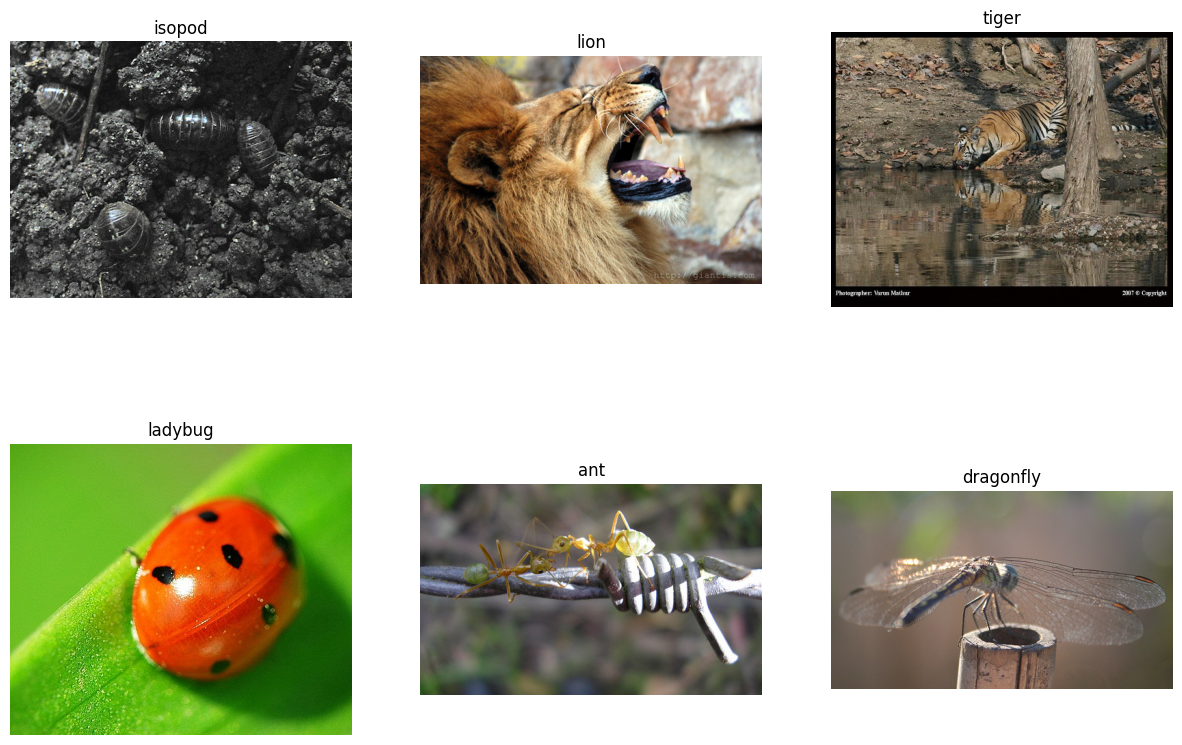

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)


def show(img, label_1, num, label_2=""):
    ax = plt.subplot(2, 3, num + 1)
    plt.imshow(img)
    plt.title(label_1)
    ax.set_xlabel(label_2)
    plt.axis("off")


for i in range(6, 12):
    img, label = microImgNet[i * 6]
    name = microImgNet.labels[i * 6][1]
    show(img, name, i-6)

# Baseline (AlexNet 2012)

[[article] 🎓 ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

Создатели: Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton
**University of Toronto**

Современный бум нейросетевых технологий начался в 2012 году, когда AlexNet с большим отрывом от конкурентов победила в ImageNet.

В AlexNet есть все компоненты, которые мы рассматривали ранее. Её архитектура состоит из пяти свёрточных слоёв, между которыми располагаются pooling-слои и слои нормализации, а завершают нейросеть три полносвязных слоя.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/alexnet_architecture.png"  width="800"></center>

<center><em>Архитектура сети AlexNet</em></center>

[[blog] ✏️ Подробнее про AlexNet](https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide)

Можно заметить, что нейросеть состоит из **двух работающих параллельно нейросетей**, которые обмениваются информацией после 2-го и 5-го сверточного слоя и в полносвязных слоях. Это было необходимо, т.к. для обучения использовались **GPU GTX580** с 3 ГБ видеопамяти. Авторы архитектуры использовали две видеокарты, работающие параллельно. На вход нейронной сети подавалось трёхканальное изображение с пространственными размерами $224 \times 224$ пикселя, к которому применялось $96$ свёрток с ядром $11 \times 11 \times 3$ и сдвигом $4$. Веса, соответствующие первым $48$ свёрткам, хранились на первой видеокарте, а оставшиеся $48$ свёрток были связаны со второй видеокартой.


- **Пространственные размеры** карты признаков резко сжимаются: $224\times224 \to 55\times55 \to 27\times27 \to 13\times13 \to 13\times13 \to 13\times13$.

- При этом увеличивается **количество сверток** (фильтров) в каждом слое: $96 (48\times2) \to 256 (128\times2) \to 384 (192\times2) \to 256 (128\times2)$.

- На выходе нейросети стоят два **полносвязных слоя**, формирующие ответ (в **ImageNet** 1000 классов).

**AlexNet** невозможно напрямую использовать для классификации **CIFAR-10**. Если так агрессивно уменьшать изображение размером $32\times32$ px, то в определенный момент в него просто не поместится следующий фильтр, который нужно применить. Можно сделать **resize** изображения с $32\times32$ до $224\times224$, но это не самый рациональный способ использования вычислительных ресурсов.

**Структура** некоторых (особенно старых) сетей, обученных под **ImageNet**, напрямую **зависит от размера изображений**. В более современных сетях есть слой [Adaptive Average Pooling 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), позволяющий решить эту проблему, но о нем мы расскажем чуть позже.

Такая архитектура показала прорывную точность: 2 место имело ошибку **26.2%** против **15.3%** у AlexNet.

<center><em><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/alexnet_architecture_with_parameters.png"></em></center>
<center><em>Архитектура сети AlexNet c параметрами слоев</em></center>

Нестандартные решения, принятые разработчиками **AlexNet**:
* Использование **ReLU** в качестве функции активации. Предшественники использовали ограниченные функции, типа сигмоиды или тангенса, которые приводили к затуханию градиента.
* Использование авторской **нормализации**. Позже было показано, что их нормализация не давала значительного прироста скорости обучения и качества модели. В современных моделях чаще используется Batch-нормализация.
* Использование различных **методов предобработки** входных данных, таких как повороты, увеличение, зашумление и т.д. для увеличения разнообразия входных данных. Это называется аугментация, и о ней вы узнаете в других лекциях.
* Использование **Dropout** = $0.5$ (при обучении отключается случайная половина нейронов).
* Использование **SGD Momentum** = $0.9$. Для обеспечения сходимости авторы использовали эвристику для **понижения скорости обучения** (learning rate)
* **Скорость обучения** стартует со значения $10^{-2}$ и уменьшается в $10$ раз, когда качество перестает расти.
* **L2 регуляризация** с весом $5 \cdot 10^{-4}$.
* Использование **ансамбля** из $7$ обученных из различного начального состояния моделей. Результат работы моделей усредняется. Данное решение увеличило точность с $81.8\%$ до $84.6\%$.


Сравним реализацию в PyTorch с оригинальной. В чем отличия?

In [ ]:
from torchvision import models

alexnet = models.alexnet(weights="AlexNet_Weights.DEFAULT")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 134MB/s]


In [ ]:
from torchsummary import summary

print("AlexNet architecture")
print(summary(alexnet, (3, 224, 224), device="cpu"))
print(alexnet)

AlexNet architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-

В PyTorch версии:
- отсутствуют нормализации,
- отсутствует разделение на две видеокарты,
- немного изменено количество сверток на некоторых слоях,
- добавлен слой Adaptive Average Pooling.

Количество слоев и размеры сверток те же.

Проверим, как работает:

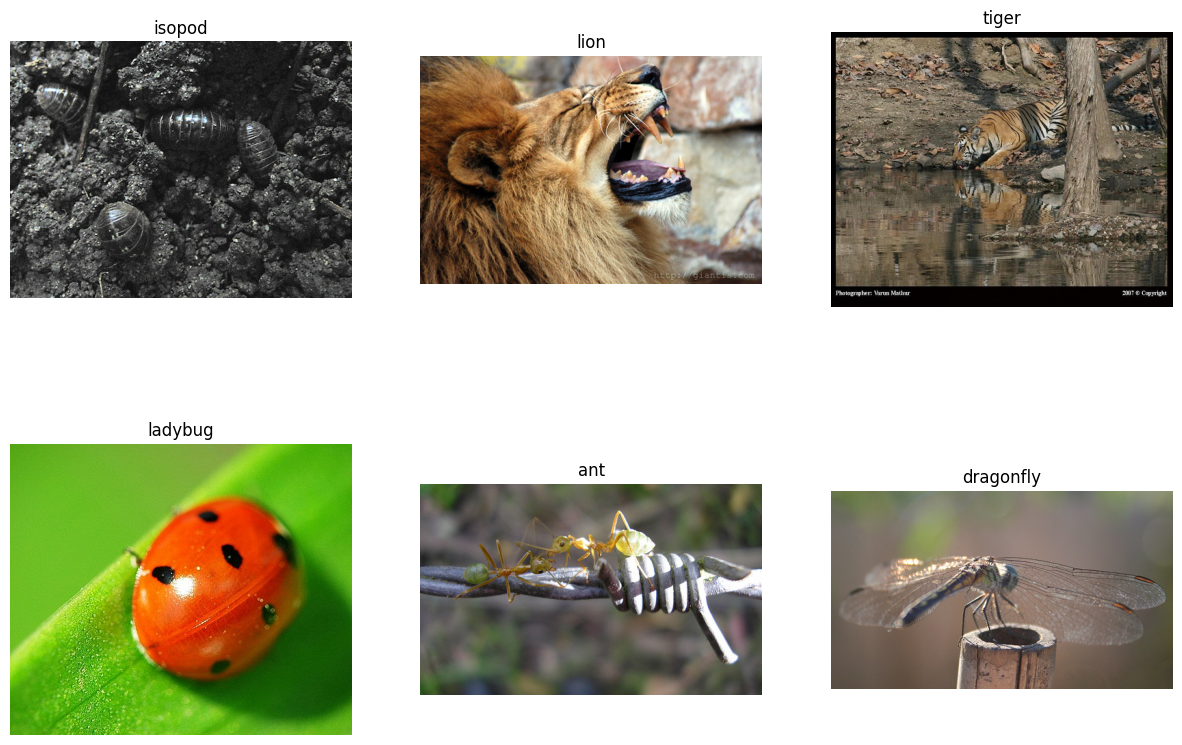

In [ ]:
import torch
import torchvision.transforms.functional as F


def img2tensor(img):
    t = F.to_tensor(img)
    t = F.normalize(t, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    return t


def catId2names(nums):
    titles = []
    for num in nums:
        titles.append(imagenet_labels[str(num.item())][1])
        titles.reverse()
    return ", ".join(titles)


for i in range(6, 12):
    img, label = microImgNet[i * 6]
    tensor = img2tensor(img)
    out = alexnet(tensor.unsqueeze(0))  # Add batch dimension
    labels_num = torch.argsort(out[0])  # Ascending order
    weights = out[0][-5:]
    predicted = catId2names(labels_num[-5:])  # Top 5
    titles = []
    name = microImgNet.labels[i * 6][1]
    show(img, name, i - 6, predicted)

## Метрики ImageNet

([[doc] 🛠️ ILSVRC](http://image-net.org/challenges/LSVRC/2017/))


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/imagenet_large_scale_visual_recognition_challenge.png"  width="900"></center>


<center><em>Лучшие результаты конкурса ILSVRC по годам.</em></center>

На каждом изображении может быть один или несколько предметов, относящихся к одному из **1000** классов.
Для метрики *Тop5* алгоритм выдает метки 5 классов. Если предмет, относящийся к одному из этих классов, есть на изображении, то ответ засчитывается как верный.
Для *Top1*, соответственно, принимается только метка одного класса.



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/imagenet1.png" width="700" >

<em>Source: <a href="https://image-net.org/">ImageNet</a></em>

## Тюнинг гиперпараметров (ZFnet)

[[arxiv] 🎓 Visualizing and Understanding Convolutional Networks (Zeiler et al., 2013)](https://arxiv.org/abs/1311.2901)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/zfnet_architecture.png"  width="1000"><center>

<center><em>Архитектура сети ZFNet </em><center>



*Тюнингованный AlexNet*

Нейросеть **ZFNet**, созданная учеными из Йорского университета, в 2013 году выиграла соревнования, достигнув результата 11.7%. В ней **AlexNet** использовалась в качестве основы, но с изменёнными параметрами и слоями.

Отличия от **AlexNet** небольшие:
* Немного поменялись пространственные размеры фильтров (было 11, стало 7);
* Увеличилось общее количество фильтров.

Количество слоев и общая структура сети, когда слои свёртки и пулинга чередуются друг с другом, а затем идут два полносвязных слоя, сохранились.

# Базовый блок (VGGNet 2014)


[[arxiv] 🎓 Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan et al., 2014)](https://arxiv.org/abs/1409.1556)

Karen Simonyan and Andrew Zisserman (Visual Geometry Group — **Oxford**)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/vggnet_architecture.png"  width="400" rotate="180"></center>
<center><em>Сравнение архитектур сетей AlexNet, VGG16 (использует 16 слоев) и VGG19 (использует 19 слоев)</em></center>




[[doc] 🛠️ Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

В 2014-ом году в Оксфорде была разработана модель **VGGNet**.

В архитектуре **VGGNet** появляется идея повторения стандартных блоков и увеличения глубины нейросети повторением таких блоков (**stacking**). На момент создания данной архитектуры идея увеличения глубины нейросети для получения лучших результатов не была очевидна. Стандартный блок **VGGNet** состоит из нескольких слоев свертки (от 2 до 4) и max-pooling слоя.

Существует несколько вариантов **VGGNet** архитектуры. Самые известные: **VGG11**, **VGG16** и **VGG19**. Цифра ставится по количеству слоев с обучаемыми весами: сверточных и полносвязных слоев.

На изображении выше показаны сети **AlexNet** и две версии **VGG16** и **VGG19** с 16 и 19 обучаемыми слоями соответственно. На соревнованиях победила более глубокая **VGG19**, показавшая процент ошибок при классификации top-5 7.3% (у **AlexNet** 15.4%).

Интересные факты о **VGGNet**:
* данная архитектура получила 2-е место в задаче классификации и 1-е место в задаче локализации (классификация и обводка объекта ограничивающей рамкой) на **ImageNet**;
* авторы **VGGNet** отказались от слоев нормализации;


Особенности архитектуры **VGGNet**:
* все свёрточные слои имеют фильтры с рецептивным полем размера **3×3**;
* сверточные слои  объединены в блоки, состоящие из некоторого количества свёрток с разным (постепенно увеличивающимся от блока к блоку) количеством фильтров;
* между блоками располагаются слои пулинга.

Появление "стандартных" блоков внутри модели — важное нововведение. Идея базового блока внутри сети будет достаточно широко использоваться дальше.

Разберем на коде:

In [ ]:
from torchvision import models

vgg = models.vgg16(
    weights=None
)  # Change on True if you want to use VGG to predict something
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Чтобы понять смысл использования сверток $3\times3$, необходимо познакомиться с понятием рецептивного поля и научиться оценивать количество необходимых вычислительных ресурсов.

## Вычислительные ресурсы



Какие ресурсы нужны для работы нейронной сети?
* Память для хранения промежуточных представлений.
* Память для обучаемых параметров.
* Вычислительные ресурсы.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/weights_memory.png"  width="650"></center>
<center><em>Пример свертки с фильтрами малого размера.</em></center>

Для случая, когда количество каналов не меняется, фильтры и изображения квадратные, `stride = 1` и `padding = "same"`:

$$ \large \text{weights} = K^2C^2 $$

$$ \large \text{flops} = K^2C^2H^2 $$




$\color{orange}{\text{Оранжевый тензор}}$ — карта признаков, поступившая на вход сверточного слоя. Параметры $H_{in}$, $W_{in}$, $C_{in}$ — длина, ширина и глубина (число каналов изображения или фильтров в предыдущем сверточном слое) входного тензора. Данный тензор не учитывается в затрачиваемых ресурсах, т.к. информация сохранена в предыдущем слое.

**Память для хранения промежуточных представлений** определяется **количеством элементов на выходе слоя** ($\color{blue}{\text{синий тензор}}$). Они хранятся для вычисления следующих слоев и градиентов. Необходимая память рассчитывается как:

$$\large H_{out}⋅W_{out}⋅C_{out}⋅n_{byte},$$

где $H_{out}, W_{out}, C_{out}$ — длина, ширина и глубина (число фильтров в свертке) выходной карты признаков, а $n_{byte}$ — количество байт для хранения одного элемента ($4$ для `float32`).

**Память для обучаемых параметров** определяется **весами и смещением** (bias) фильтров свертки ($\color{green}{\text{зеленые тензоры}}$). Необходимая память рассчитывается как:

$$\large (K_h⋅K_w⋅C_{in}⋅C_{out} + С_{out})⋅n_{byte},$$

где $K_h, K_w, C_{in}$ — длина, ширина и глубина одного фильтра, $C_{out}$ — число фильтров в свертке.

Для оценки необходимых **вычислительных ресурсов** посчитаем **количество операций** сложения и умножения при прямом проходе. Каждое число выходного тензора является результатом применения фильтра свертки к некоторому рецептивному полю входного тензора. Количество операций можно оценить как произведение количества элементов на выходе слоя на размер одного фильтра:

$$\large (H_{out}⋅W_{out}⋅C_{out})⋅(K_h⋅K_w⋅C_{in}).$$


**Оценка памяти для хранения параметров слоя:**

In [ ]:
import torch.nn as nn

conv_sizes = [11, 7, 5, 3]

for conv_size in conv_sizes:
    conv_layer = nn.Conv2d(3, 64, conv_size, stride=1, padding=1)
    print("Convolution size: %ix%i" % (conv_size, conv_size))
    for tag, p in conv_layer.named_parameters():
        print("Memory reqired for %s: %.2f kb" % (tag, (np.prod(p.shape) * 4) / 1024))

Convolution size: 11x11
Memory reqired for weight: 90.75 kb
Memory reqired for bias: 0.25 kb
Convolution size: 7x7
Memory reqired for weight: 36.75 kb
Memory reqired for bias: 0.25 kb
Convolution size: 5x5
Memory reqired for weight: 18.75 kb
Memory reqired for bias: 0.25 kb
Convolution size: 3x3
Memory reqired for weight: 6.75 kb
Memory reqired for bias: 0.25 kb


**Оценка количества вычислительных операций (для одной свертки):**

* $11×11: (224 * 224 * 64) * (3 * 11 * 11) = 9 633 792 * 11 * 11 =  9 633 792 * 121  = 1 165 688 832$

* $7×7: (224 * 224 * 64) * (3 * 7 * 7) = 9 633 792 * 7 * 7 = 9 633 792 * 49 = 472 055 808$

 $121:49 \approx 2.5 ⟶ $ в $\approx 2.5$ раза меньше, чем $11×11$

* $5×5: (224 * 224 * 64) * (3 * 5 * 5) = 9 633 792 * 5 * 5 = 9 633 792 * 25 = 240 844 800$

 $49:25 \approx 2 ⟶ $ в $\approx 2$ раза меньше, чем $7×7$

* $3×3: (224 * 224 * 64) * (3 * 3 * 3) = 9 633 792 * 3 * 3 = 9 633 792 * 9 = 86 704 128$

 $25:9 \approx 2.7$ ⟶ в $\approx 2.7$ раза меньше, чем $5×5$


Уменьшение размера ядра свертки приводит к существенному уменьшению количества вычислительных операций







In [ ]:
# вычислительно всегда выгоднее свертки 3х3

### Фильтры 3×3

**Рецептивное поле** — участок входной карты признаков (входного тензора), который при прохождении одного или нескольких слоев нейронной сети формирует один признак на выходе (одно число выходного тензора). **Рецептивное поле** можно назвать “полем зрения”.

Интуитивно кажется, что чем больше “поле зрение”, тем лучше обобщающая способность свертки. Авторы **VGG** решили отказаться от свертки **5×5** и заменить ее двумя свертками **3×3**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/receptive_field_size.png"  width="850"></center>
<center><em>Две свёртки 3×3 вместо одной 5×5.</em></center>


Рассмотрим **рецептивное поле** свертки **5×5** ($\color{green}{\text{зеленый квадрат}}$ на A1). Применение свертки **5×5** к этому квадрату даст 1 признак на выходе ($\color{red}{\text{красный квадрат}}$ на A3). Применение к этому же **рецептивному полю** свертки **3×3** ($\color{orange}{\text{оранжевые квадраты}}$ на A1) даст на **3×3** признака ($\color{red}{\text{красный квадрат}}$ на A2), применение второй свертки **3×3** позволит получить 1 признак на выходе ($\color{red}{\text{красный квадрат}}$ A3).

**Итого:** одна свертка **5×5** имеет то же **рецептивное поле**, что две свертки **3×3**.

При этом применение двух сверток **3×3** дает ряд преимуществ:

* меньшее количество параметров. При применении свертки **5×5** необходимо обучать $5⋅5⋅C_{in}⋅C_{out} = 25⋅C_{in}⋅C_{out}$  весов, где $С_{in}$ — глубина входной карты признаков, $C_{out}$ — количество фильтров сверточного слоя. При применении двух сверток **3×3** обучается $2⋅(3⋅3⋅C_{in}⋅C_{out}) = 18⋅C_{in}⋅C_{out}$  весов.
* между свертками **3×3** добавляется дополнительный **слой активации**, который позволяет формировать более сложные признаки.

**2 маленьких фильтра работают как один большой или даже лучше!**

Аналогично 3 свертки **3×3** могут заменить одну свертку **7×7**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/receptive_field_size_example.png"  width="850"></center>
<center><em>Три свёртки 3×3 вместо одной 7×7.</em></center>


### Память для хранения параметров (VGG16)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/memory_and_parameters_vgg16.png"  width="800"></center>
<center><em>Архитектура VGG16 с параметрами слоев </em></center>

Благодаря такой экономии получилось сделать большую по тем временам сеть (16 слоев).  Тем не менее, несмотря на применённые способы уменьшения вычислительной сложности и снижение числа параметров, сеть все равно получилась огромной (16-слойная версия сети VGG расходует в 25 раз больше дорогой памяти GPU, нежели AlexNet).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/compare_parameters_alexnet_and_vgg16.png"  width="900"></center>
<center><em>Сравнение параметров AlexNet и VGG16.</em></center>


* Основная часть памяти расходуется на большие свёртки в начальных слоях, где пространственные размеры (ширина и высота) велики;
* Больше всего весов в полносвязных слоях;
* Вычислительные ресурсы нужны в первую очередь для сверток.

VGG-16 получилась существенно больше по сравнению с и так довольно объемной AlexNet, и тем более по сравнению с современными моделями.

В значительной степени с этим связано дальнейшее направление развития моделей. В следующем году ImageNet выиграла сеть под названием Inception.


### Контроль GPU

In [ ]:
!nvidia-smi

Sun Nov 26 17:25:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Чтобы контролировать расход памяти в процессе обучения, установим библиотеку для мониторинга ресурсов GPU:

In [ ]:
!pip install -q GPUtil

  Preparing metadata (setup.py) ... done


In [ ]:
import GPUtil as GPU
import psutil
import os


def gpu_usage():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    if len(GPUs) == 0:
        return False
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print(
        f"GPU RAM Free: {gpu.memoryFree:.0f}MB \
    | Used: {gpu.memoryUsed:.0f}MB \
    | Util {gpu.memoryUtil*100:3.0f}% \
    | Total {gpu.memoryTotal:.0f}MB"
    )

Посмотрим, сколько памяти потребуется **VGG19** и какого размера batch можно использовать.

In [ ]:
import torchvision
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg19 = torchvision.models.vgg19(weights=None, progress=True)
vgg19.requires_grad = True
vgg19.to(device)

gpu_usage()  # Common GPU info

vgg19.train()

for batch_size in [1, 8, 16, 32, 64]:
    input_random = torch.rand(batch_size, 3, 224, 224, device=device)
    out = vgg19(input_random)
    print("Batch size", batch_size)
    gpu_usage()

GPU RAM Free: 13870MB     | Used: 1231MB     | Util   8%     | Total 15360MB
Batch size 1
GPU RAM Free: 13332MB     | Used: 1769MB     | Util  12%     | Total 15360MB
Batch size 8
GPU RAM Free: 12518MB     | Used: 2583MB     | Util  17%     | Total 15360MB
Batch size 16
GPU RAM Free: 11438MB     | Used: 3663MB     | Util  24%     | Total 15360MB
Batch size 32
GPU RAM Free: 8888MB     | Used: 6213MB     | Util  40%     | Total 15360MB
Batch size 64
GPU RAM Free: 4572MB     | Used: 10529MB     | Util  69%     | Total 15360MB


Очистка памяти:

In [ ]:
gpu_usage()

GPU RAM Free: 4572MB     | Used: 10529MB     | Util  69%     | Total 15360MB


In [ ]:
input_random = None  # del input
out = None  # del out
gpu_usage()

GPU RAM Free: 4572MB     | Used: 10529MB     | Util  69%     | Total 15360MB


In [ ]:
torch.cuda.empty_cache()
gpu_usage()

GPU RAM Free: 9136MB     | Used: 5965MB     | Util  39%     | Total 15360MB


In [ ]:
vgg19 = None
gpu_usage()

GPU RAM Free: 9136MB     | Used: 5965MB     | Util  39%     | Total 15360MB


In [ ]:
torch.cuda.empty_cache()

In [ ]:
gpu_usage()

GPU RAM Free: 13412MB     | Used: 1689MB     | Util  11%     | Total 15360MB


# Inception module (GoogLeNet 2014)

[[arxiv] 🎓 Going Deeper with Convolutions (Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842)

**GoogLeNet** (на самом деле архитектура называется **Inception**, а **GoogLeNet** — это имя команды в соревновании  [**ILSVRC14**](https://www.image-net.org/challenges/LSVRC/2014/), названной так в честь нейронной сети Яна Лекуна **LeNet 5**, но до сих пор первую версию сети **Inception** называют **GoogLeNet**) — ещё более глубокая архитектура с 22 слоями.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/inception_module_googlenet.png"  width="500"></center>

В отличие от предыдущих нейросетей, **GoogLeNet** разработана в коммерческой компании с целью практического применения, поэтому основной упор был сделан на эффективность.

 Она содержит менее 7 миллионов параметров — в 9 раз меньше, чем у **AlexNet**, и в 20 раз меньше, чем у **VGG19**. При этом сеть оказалась немного более точной, чем **VGG19**: ошибка снизилась с 7.3% до 6.7%.

Рассмотрим, за счёт чего удалось достичь такого огромного выигрыша в ресурсах, так как многие идеи, которые впервые были использованы для **GoogLeNet**, активно применяются до сих пор.

Составной блок **GoogLeNet** называется **Inception module**. Архитектура **GoogLeNet** состоит из множества таких блоков, следующих друг за другом.

Идея **Inception module** состоит в том, чтобы производить параллельные вычисления сверток с различным размером рецептивного поля и Max Pooling, конкатенируя (объединяя, а не складывая) полученные результаты. Это позволяет выделять признаки разного размера и сложности.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/naive_inception_module.png"  width="500"></center>
<center><em>Наивная реализация Inception module </em></center>

In [ ]:
# посмотреть свертки 1 на 1, делают, чтобы регулировать размер, число каналов

На рисунке выше представлена наивная реализация **Inception module**. Данная реализация имеет очень важный недостаток: **увеличение глубины карты признаков**. За счет конкатенации выходов **сверток** и **Max Pooling** из 256 каналов на входе мы получаем 672 канала на выходе. Количество каналов изображения увеличилось более чем в 2.6 раза. За 9 таких блоков глубина увеличится более чем в 5000 раз!

Такое решение плохо совместимо с экономией ресурсов.

Стоит также заметить, что слой **Max Pooling** в данной архитектуре имеет шаг 1 и не изменяет пространственные размеры карты признаков.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/naive_inception_module_with_dimension_reduction.png"  width="850"></center>

<center><em>Наивные реализации Inception module и Inception module с уменьшением размерности</em></center>


Как мы уже показали, при использовании наивной реализации **Inception module** количество фильтров возрастает от слоя к слою.

Чтобы этого избежать, введены так называемые **«бутылочные горлышки»** — слои с фильтром **1×1**, уменьшающие глубину изображения. Благодаря им удалось достичь того, чтобы количество каналов на входе и на выходе либо не менялось, либо менялось только в моменты, когда это необходимо.

Интересно, что слой свертки **1×1** ставится после слоя **Max Pooling**. Это позволяет более эффективно преобразовывать признаки.

In [ ]:
import torchvision

# https://pytorch.org/vision/stable/_modules/torchvision/models/googlenet.html#googlenet
googlenet = torchvision.models.googlenet(init_weights=True)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

##### 1×1 Convolution





<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/1x1_convolution.png"  width="550"></center>
<center><em>Уменьшение глубины изображения с помощью 32 фильтров 1×1.</em></center>


Свёртку **1×1** можно сравнить с линейным слоем полносвязной нейронной сети. Мы берем вектор из карты признаков (столбик 1×1×64 на картинке) и домножаем на матрицу весов (одну для всех векторов, в данном случае матрица будет 64×32, т.к. она составлена из 32 фильтров с размерами 1×1×64), чтобы получить вектор на выходе (столбик 1×1×32 на картинке).

Это одновременно формирует более сложные признаки, собирая информацию с различных сверток и **Max Pooling**, и позволяет сократить их количество.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/naive_inception_module_with_dimension_reduction_parameters.png"  width="700"></center>
<center><em> Реализация Inception module с уменьшением размерности </em></center>


Количество параметров уменьшается в два с лишним раза по сравнению с наивной реализацией. Сеть получается значительно экономичнее.

Использование таких модулей и отсутствие полносвязных слоёв делают **GoogLeNet** очень эффективной и достаточно точной сетью. Но это далеко не все нововведения, которые появились в этой модели.

## Stem network

В составе **GoogLeNet** есть небольшая подсеть — **Stem Network**. Она состоит из трёх свёрточных слоёв (первый с большим фильтом) с двумя pooling-слоями и располагается в самом начале архитектуры. Цель этой подсети — быстро и сильно уменьшить пространственные размеры (сжать изображение перед параллельной обработкой), чтобы минимизировать количество элементов в слоях.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/stem_network.png" width="1024"></center>
<center><em>Архитектура GoogLeNet. В первых слоях быстро уменьшаются пространственные размеры. </em></center>

## Global Average Pooling

Отдельного внимания заслуживает завершающая часть сети. В **AlexNet** и **VGGNet** мы привыкли видеть в конце сети вытягивание карты признаков в вектор и два полносвязных слоя. В **GoogLeNet** один из полносвязных слоев заменен на
**Global Average Pooling**.

[[arxiv] 🎓 Network In Network, Lin et al., 2013](https://arxiv.org/abs/1312.4400)



Этот слой просто усредняет все значения в канале. На выходе получаем вектор признаков количество элементов в котором равно количеству каналов.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/global_average_pooling.png" width="450"></center>
<center><em>Global Average Pooling</em></center>

In [ ]:
# например зеленая карта признаков отвечает за наличие или отсутствие хвоста
# у собаки, а после глобал авераж пулинга зеленая точка - ответ да или нет

Плюсы **GAP**:

* независимость от размера входа;
* регуляризация (препятствует переобучению);
* уменьшение числа параметров;


В PyTorch можно реализовать GAP при помощи класса `nn.AdaptiveAvgPool2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html). При создании экземпляра класса указываем, какую пространственную размерность мы хотим получить на выходе. При `output_size = 1`получим результат как на иллюстрации.

In [ ]:
gap = torch.nn.AdaptiveAvgPool2d(1)
dummy_input = torch.randn(1, 3, 6, 6)
out = gap(dummy_input)
print("Raw out shape", out.shape)
out = nn.Flatten()(out)
print("Flatten out shape", out.shape)

Raw out shape torch.Size([1, 3, 1, 1])
Flatten out shape torch.Size([1, 3])


[[blog] ✏️ Max Pooling and Global Average Pooling](https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md)

На выходе последнего **Inception module** формируется карта признаков **7×7×1024**. Если вытянуть их в линейный слой, получится более 50 тысяч признаков.

Идея слоя **Global Average Pooling** (GAP) в том, что все пространственные размеры, какими бы они ни были (например, 7×7, как в **Inception**, или 6×6, как на картинке), сворачиваются в 1×1.

Мы берем среднее значение независимо по каждому каналу полученной карты признаков.

Ранее считалось, что применение **Global Average Pooling** в составе архитектуры сверточной нейронной сети (CNN), то есть осуществление поканального усреднения пространственных измерений тензора, приведёт к полной потере пространственной информации о переданном сети объекте. Тем не менее, последние [исследования 🎓[arxiv]](https://arxiv.org/abs/2108.07884) показывают, что после такого преобразования часть пространственной информации всё же сохраняется. Несмотря на то, что семантическая информация (например информация о точных границах объекта), полностью утрачивается после Global Average Pooling, информация об абсолютном положении объекта на исходном изображении сохраняется и оказывается закодированной порядком следования компонент в оставшемся векторе усреднённых фильтров.

Применяя **GAP**, мы сократили количество признаков в 49 раз! Кроме того, **Global Average Pooling** уменьшает переобучение, т.к. мы избавляемся от влияния менее важных признаков.


In [ ]:
import torch.nn as nn
from PIL import Image
import torch


def file2tensor(filename):
    img = Image.open(filename)
    t = torchvision.transforms.functional.to_tensor(img)
    t = torchvision.transforms.functional.normalize(
        t, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    )
    return t


class CNNfromHW(nn.Module):
    def __init__(self, conv_module=None):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)  # 16xHxW
        self.pool = nn.MaxPool2d(2, 2)  # 16 x H/2 x W/2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 32 x H/2 x W/2
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Any spatial size -> 32x1x1
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        print("Input shape", x.shape)
        x = self.conv1(x)  # 16xHxW
        x = self.pool(x)  # 16 x H/2 x W/2
        x = self.conv2(x)  # 32 x H/2 x W/2
        x = self.activation(x)  # Any spatial size -> 32x1x1
        x = self.gap(x)
        scores = self.fc(x.flatten(1))
        print("Output shape", scores.shape)
        return scores


print("CIFAR10 like")
input_random = torch.rand(1, 3, 32, 32)
model_with_gap = CNNfromHW()
out = model_with_gap(input_random)


print("Arbitrary size")
# Different sizes work too!
aramdillo_t = file2tensor("imagen/n02454379_10511_armadillo.jpg")
out = model_with_gap(aramdillo_t.unsqueeze(0))

CIFAR10 like
Input shape torch.Size([1, 3, 32, 32])
Output shape torch.Size([1, 10])
Arbitrary size
Input shape torch.Size([1, 3, 500, 500])
Output shape torch.Size([1, 10])


## Затухание градиента

**GoogLeNet: дополнительный классификатор**

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/googlenet_additional_classificator.png"  width="900"></center>
<center><em>Архитектура GoogLeNet. Отдельно вынесен блок — дополнительный классификатор</em></center>


Помимо основного классификатора на выходе сети добавлены два дополнительных классификатора, встроенных в промежуточные слои. Они понадобились для того, чтобы улучшить обратное распространение градиента,  без батч-нормализации в таких глубоких сетях градиент очень быстро затухал, и обучить сеть такого размера было серьёзной проблемой.

Обучение VGG осуществлялось непростым способом: сначала обучали 7 слоев, затем добавляли туда следующие и обучали это вручную. Без использования батч-нормализации вряд ли получится повторить результат.

Google подошел более системно, добавив дополнительные выходы, которые способствовали тому, чтобы градиент меньше затухал. Благодаря этому удалось решить серьёзную на тот момент проблему, которая ограничивала возможность обучения глубоких моделей.
Статья про батч-нормализацию появилась как раз в 15-ом году, видимо, уже после выхода этой модели.

# Batchnorm (революция глубины)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/deep_models.png"  width="750"></center>
<center><em>Победители ImageNet Large Scale Visual Recognition Challenge (ILSVRC)</em></center>


В 2015 году вышла статья [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift 🎓[arxiv]](https://arxiv.org/abs/1502.03167). Благодаря добавлению слоя BatchNorm стало технически возможно обучать сети состоящие из десятков слоев.

Но точность с увеличением глубины не росла:

[[arxiv] 🎓 Deep Residual Learning for Image Recognition (He et al., 2015)](https://arxiv.org/abs/1512.03385)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/resnet_20_and_56_layers.png"  width="550"></center>
<center><em>График ошибки на обучающей и тестовой выборках двух модификаций
VGGNet с 20 и 56 слоями соответственно в ходе процесса обучения </em></center>

На графике выше приведено сравнение графиков обучения 56-слойной и 20-слойной сетей Microsoft, построенных на принципах VGGNet. Как видно из графиков, у 56-слойной сети и на тренировочном, и на тестовом датасете ошибка больше, чем у 20-слойной. Казалось бы, сеть, состоящая из большего количества слоёв, должна работать как минимум не хуже, чем сеть меньшего размера. К сожалению, проблема **затухания градиента** в этом случае не позволяет эффективно обучить более глубокую сеть.

В 2015 году соревнования выиграла сеть **ResNet**, архитектура которой предлагала новый подход к решению проблемы обучения глубоких сетей. Она состояла из 152 слоёв и снизила процент ошибок до 3,57%. Это сделало её почти в два раза эффективнее **GoogLeNet**.

При обучении нейронной сети методом обратного распространения ошибки модуль градиента постепенно уменьшается, проходя через каждый из слоёв сети. В глубоких сетях "длина" такого пути оказывается достаточной для того, чтобы модуль градиента стал мал и процесс обучения фактически остановился. В архитектуре **ResNet** такая проблема решается отказом от простого последовательного соединения слоёв (stacking) в пользу создания дополнительных связей в вычислительном графе нейронной сети, через которые градиент смог бы распространяться, минуя свёрточные слои и таким образом не затухая.

Сеть архитектуры **ResNet** состоит из набора так называемых **Residual Block**-ов. В данном блоке тензор входных признаков пропускается через пару последовательно соединённых свёрточных слоёв, после чего полученный результат складывается поканально с этим же неизменённым входным тензором. Свёрточные слои в таком блоке аппроксимируют не саму функциональную зависимость между входным и выходным тензором, а разность (анг. residual) между такой искомой зависимостью и тождественным преобразованием.

# Skip connection (ResNet 2015)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/residual_connection.png"  width="800"></center>
<center><em>Сравнение Residual Block с "обычными" слоями</em></center>


Идея **Residual Block** состоит в уточнении набора признаков на каждом блоке. Вместо того, чтобы перезаписывать признаки, мы добавляем к выходу предыдущего блока уточнение, сформированное на этом блоке.

Бонусы **Residual Block**:
- канал суммирования позволяет градиенту легко распространяться без затухания;
- не теряется информация о важных признаках, выделенных на предыдущем слое.

## Архитектура ResNet

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/resnet_architecture.png"  width="730"></center>
<center><em>Архитектура ResNet. Используется стаккинг residual blocks, каждый residual block состоит из двух 3×3 conv слоев, переодически количество фильтров в свертках удваивается, а размер выходных слоев уменьшается в 2 раза (за счет stride = 2). Добавился дополнительный conv слой в начале сети. Отсутствуют FC слои (кроме последнего, который предсказывает класс).</em></center>


Из таких блоков можно построить очень глубокую сеть (были эксперименты из 1000 слоев). Для решения конкретной задачи — победы на **ImageNet** — хватило 150 слоев (добавление большего количества блоков уже не давало прироста точности).

В **ResNet** используются многие идеи, которые присутствовали в предыдущих моделях:
- вначале изображение резко уменьшается,
- дальше используются блоки 3×3, как в **VGGNet**,
- применяется **Average Pooling** вместо полносвязного слоя.

Блоки состоят из конструкций, изображенных выше:
- две свёртки 3×3,
- batch normalization после каждой свертки,
- функции активации ReLU,
- прибавление результата предыдущего слоя.

## BasicBlock в PyTorch




Код базового блока

In [ ]:
import inspect
import torchvision.models.resnet as resnet

# BasicBlock
code = inspect.getsource(resnet.BasicBlock.forward)
print(code)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



Так выглядит в коде базовый блок для сетей, в которых меньше 50 слоёв: свёртка, батч-нормализация, активация, свёртка, батч-нормализация.

Если свойство `downsample != None`, то вызывается слой **downsample**. Это свёртка 1×1 с шагом 2, уменьшающая пространственные размеры карты признаков.

[[doc] 🛠️ Модель ResNet на Torchvision](https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#resnet18)


Вот как инициализируются блоки (в первом сжатие происходит, во втором — нет).

In [ ]:
from torchvision import models

resnet = models.resnet18(weights=None)
print(resnet.layer2)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

## Bottleneck layer

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/resnet_bottleneck_layer.png" width="500"></center>
<center><em>В более глубоких сетях (ResNet-50+) для повышения эффективности используется слой "bottleneck" (похожим образом, что и в GoogLeNet)</em></center>

Стоит отметить, что сеть **ResNet-152** имеет существенно меньше обучаемых параметров, чем **VGG-19** (58 миллионов против 144 миллионов).

Это достигнуто за счёт того, что в более глубоких сетях, помимо упомянутых Residual Block-ов с двумя свёрточными слоями с ядром 3×3, применялся более эффективный блок — **bottleneck**, состоящий из:
- свёртки 1×1 с уменьшением количества фильтров,
- свертки 3×3 с маленьким количеством фильтров,
- свертки 1×1, восстанавливающие количество фильтров до начальных значений, чтобы к ним можно было прибавить вход.

## Обучение ResNet

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/resnet_18_and_34_layers.png"  width="700"></center>
<center><em>График изменения ошибки при обучении двух модификаций ResNet с 34 и 18 слоями соответственно</em></center>


При обучении **ResNet** шаг обучения понижали вручную, когда точность выходила на плато.

Помимо того, что **ResNet** c огромным отрывом выиграла ImageNet у моделей прошлого года, она стала первой моделью, превысившей точность человеческой разметки. Решения на базе этой архитектуры также стали победителями на соревнованиях по детектированию и сегментации.

### Обогащение карт признаков

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/resnet_features_flow.png"  width="900"></center>

Можно взглянуть на архитектуру ResNet под таким углом: на первых слоях мы получаем базовую карту признаков, а на последующих улучшаем ее, прибавляя к ней новые уточненные признаки.

# Grouped Convolution



В AlexNet выходы первого слоя обрабатывались параллельно: половина каналов отправлялось на одну видеокарту а половина — на другую.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/alexnet_architecture.png"  width="600"></center>


Только на последних слоях полученные признаки объединялись.

Можно рассматривать такой подход как ансамблирование, как минимум, он позволяет выполнять часть операций параллельно и таким образом ускорить вычисления.

Эта идея реализуется при помощи Grouped convolution.  Можно поканально разделить входной тензор признаков на произвольное количество частей (групп) и сворачивать их независимо.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/groupped_convolution.png"  width="750"></center>
<center><em> Groupped Convolution с двумя группами сверток. Групповые свертки позволяют обрабатывать входные данные параллельно. В качестве бонуса — уменьшение числа параметров, и дополнительная регуляризация.</em></center>



[[blog] ✏️ A Tutorial on Filter Groups (Grouped Convolution)](https://blog.yani.ai/filter-group-tutorial/)

На картинке выше входная карта признаков разбивается на две группы по каналам. Над каждой группой свертки вычисляются независимо, а потом конкатенируются. Это позволяет заменить $D_{out}$ фильтров $H_{in} × H_{in} × D_{in}$ на $D_{out}$ фильтров $H_{in} × H_{in} × D_{in}/2$, сократив количество обучаемых весов в 2 раза.




Так как размер ядер станет меньше, получим выигрыш в производительности:

$$ \large \text{weights} = \frac{C}{G} C K^2, $$

где $G$ — количество групп.

## Grouped Convolution in PyTorch


Возможность вычисления груповой свертки в PyTorch заложена в объект  `nn.Conv2d`. Количество групп задается параметром `groups`, значение которого по умолчанию равно 1.

Сравним время, которое требуется на обычную свертку с `groups = 1` и `groups = 64` при вычислениях на CPU:

In [ ]:
# CPU test
from torch import nn
import time
import torch


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()


input_random = torch.rand(8, 512, 112, 112)
start = time_synchronized()
normal_conv = nn.Conv2d(512, 1024, 3, groups=1)
out = normal_conv(input_random)
tm = time_synchronized() - start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized()
groupped_conv = nn.Conv2d(512, 1024, 3, groups=64)
out = groupped_conv(input_random)
tm = time_synchronized() - start
print(f"Groupped convolution take  {tm} sec.")

Normal convolution take  24.837504148483276 sec.
Groupped convolution take  0.7662994861602783 sec.


И на GPU:

In [ ]:
# GPU test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start = time_synchronized()
normal_conv = nn.Conv2d(512, 1024, 3, groups=1).to(device)
out = normal_conv(input_random.to(device))
tm = time_synchronized() - start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized()
groupped_conv = nn.Conv2d(512, 1024, 3, groups=64).to(device)
out = groupped_conv(input_random.to(device))
tm = time_synchronized() - start
print(f"Groupped convolution take  {tm} sec.")

Normal convolution take  0.2818155288696289 sec.
Groupped convolution take  0.059685707092285156 sec.


Применение групповой свертки с `groups=64` дает выигрыш во времени в 21 раз на CPU и в 41 раз на GPU. Это связано с уменьшением количества вычислительных операций.

## ResNeXt

ResNeXt объединяет идеи:
* Skip connection
* Inception  
* Grouped convolution

[[arxiv] 🎓 2016 Aggregated Residual Transformations for Deep Neural Networks (Xie et al., 2016)](https://arxiv.org/abs/1611.05431)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/compare_resnet_and_resnext_blocks.png"  width="650"></center>
<center><em>Сравнение блоков ResNet и ResNeXt. ResNeXt создан тем же коллективом авторов, что и ResNet. Увеличение ширины residual block достигается путем использования параллельных веток "cardinality"), которые по духу схожи с Inception module. </em></center>

Следующая модель — **ResNeXt**. Эта сеть выиграла **ImageNet** в следующем году. Идея немного напоминает блок **Inception** в **GoogLeNet**: обрабатывать не сразу все каналы, а распараллелить обработку на несколько групп.



In [ ]:
from torchvision import models
from torchsummary import summary

resnext = models.resnext50_32x4d(weights=None)

print(summary(resnext, (3, 224, 224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/resnext_inception_grouped_convolution.png"  width="1000">


[[blog] ✏️ Review of ResNet Family: from ResNet to ResNeSt](https://sheng-fang.github.io/2020-05-20-review-resnet-family/)

Альтернативой для блока **ResNeXt** (рисунок слева) является блок **Inception-ResNeXt** (рисунок посередине), объединивший идеи **ResNeXt** блока и **Inception** блока. Применение таких блоков вместо **ResNeXt** позволяет немного улучшить результаты **ResNeXt**.

##Обзор сети MobileNet (2017 г.)

[[arxiv] 🎓 MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Howard et al., 2017)](https://arxiv.org/abs/1704.04861)

**MobileNet** — архитектура нейронной сети, специально созданная для работы на CPU мобильных устройств. Высокая скорость работы первой версии **MobileNet** достигалась благодаря разделимой по глубине свертке (**Depthwise Separable Convolution**).

Также для данной архитектуры предусматривается возможность варьировать размер входного изображения и ширину слоев.

Функцией активации у **MobileNet** обычно выступает **ReLU6** (ограничение сверху у данной функции активации призвано облегчить дальнейшую 8-битную квантизацию нейронной сети).

В 2018 году была предложена архитектура **MobileNetV2**, которая существенно превосходит первую версию благодаря добавлению к архитектуре инвертированных остаточных блоков (**Inverted Residual Block**).

А в 2019 году была предложена уже **MobileNetV3**, которая была получена при помощи автоматического поиска архитектуры (**Network Architecture Search**) и дополнительно включала в себя модули **squeeze-and-excitation** и немонотонную функцию активации **swish** ("жесткая" версия которой, hard-swish, так же призвана облегчить квантизацию).

Давайте разберемся, как все эти улучшения работают.

### Depthwise separable convolution

Обычная свертка в **CNN** одновременно работает с шириной, высотой и глубиной (каналами) карты признаков. Разделимая по глубине свёртка (**Depthwise separable convolution**) разделяет вычисления на два этапа:
- для каждого канала изображения используется свой отдельный сверточный фильтр глубины 1.  По сути это **Grouped Convolution** с количеством групп, равным числу каналов.
- после вычисляется свертка 1×1 с глубиной, равной глубине входной карты признаков.

Применение разделимой по глубине свертки позволяет уменьшить количество обучаемых параметров и вычислительных операций при небольшой потере точности.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/depthwise_and_separable_convolution.png"  width="650">

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/depthwise_separable_convolution.png"  width="650">

$\text{DepthwiseSeparableConv} = \text{GroupedConv}(\text{group} = C) + \text{Conv}(1×1)$

Количество обучаемых параметров (весов):
* для $\text{Conv2d}: \qquad \qquad \qquad \qquad \text{weights} = C^2K^2 $
* для $\text{DepthwiseSeparableConv}: \ \text{weights} = C K^2  + C^2\times1 $

Чем больше каналов, тем больше экономия.

При размере ядра $3×3$ $(K=3)$ :

$\text{Conv2d}: \qquad \qquad \qquad \qquad 3^2 C^2 $

$\text{DepthwiseSeparableConv}: \ 3^2C +C^2$


### Inverted residual block

Инвертированный остаточный блок (**Inverted residual block**) напоминает классический **residual block** из архитектуры **ResNet**, однако имеет ряд существенных отличий. Дело в том, что классический **residual block**, из-за резкого уменьшения размерности пространства в комбинации с функцией активации **ReLU**, которая уничтожает всю информацию от отрицательных значений, приводит к потере большого количества информации. Поэтому вместо уменьшения количества слоев в *середине*, оно, наоборот, увеличивается. Увеличение вычислительной сложности компенсируется использованием разделимой по глубине свертки. А на входе и выходе из блока (где количество слоев уменьшается) отсутствует нелинейность (**ReLU**).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/The-difference-between-residual-block-and-inverted-residual.png"  width="550">

# Сравнение моделей

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/compare_models_accuracy_vs_parameters.png" width="600"></center>

<center><em>Сравнение моделей по параметрам Точность vs Количество операций</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1810.00736.pdf">Benchmark Analysis of Representative Deep Neural Network Architectures (Bianco et al., 2018)</a></em></center>

Картинка из статьи 2018 года (не самая свежая), но она позволяет визуально сравнить модели по трем параметрам:
- размер модели (размер кружка),
- количество необходимых для обучения вычислительных операций (ось x)
- точность на задаче top-1 (ось y).

Здесь можно увидеть, что **VGGNet** — огромные по объёму модели, но по нынешним меркам они обладают средней точностью. Они требуют больших вычислительных ресурсов, поэтому сейчас имеет смысл их использовать разве что в учебных целях, а модели на базе **ResNet** (**ResNet-50**, **ResNet-152**) довольно хороши: в плане точности какого-то большого отрыва от них здесь не видно. Но, тем не менее, есть модели, которые работают чуть лучше. Рассмотрим их кратко, чтобы было понимание того, куда двигалась мысль в этой области.

## Много skip connection (DenseNet 2016)

[[arxiv] 🎓 Densely Connected Convolutional Networks (Huang et al., 2016)](https://arxiv.org/abs/1608.06993)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/densenet_architecture.png"  width="450"></center>
<center><em>Архитектура DenseNet. Используется несколько "обходов" и конкатенация вместо суммы. </em></center>



Еще один вариант, что можно сделать со слоями — добавить дополнительные связи в обход сверточных блоков, чтобы градиент проходил ещё лучше.

Можно также заменить сумму на конкатенацию. Чтобы не увеличить при этому глубину карт признаков, можно использовать свёртки **1×1**.

На этих двух принципах построен **DenseNet**. С точки зрения ресурсов он чуть более требовательный, чем базовый **ResNet**, и немного более точный.

## Ширина вместо глубины (WideResNet 2016)

[[arxiv] 🎓 Wide Residual Networks (Zagoruyko et al., 2016)](https://arxiv.org/abs/1605.07146)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/compare_basic_and_wide_residual_blocks.png" width="400"></center>
<center><em>Сравнение базового ResBlock и Широкого ResBlock, где используются $F × k$ фильтры вместо $F$ фильтров в каждом слое </em></center>

Другой подход состоит в том, чтобы увеличивать не глубину, а ширину модели.
Авторы утверждают, что ширина (количество фильтров) **residuals** блока — значительно более важный фактор, чем глубина нейронной сети. 50-слойный **Wide ResNet** показывает лучшие результаты, чем оригинальный 152-х слойный **ResNet**. С точки зрения вычислительных ресурсов, использование ширины вместо глубины позволяет более эффективно параллелить вычисления на GPU (parallelizable).

# Squeeze-and-Excitation (SENet 2017)

<img src = "https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/senet_conv.png" width="800">

При обычной свёртке значения всех каналов учитывались одинаково. Идея SE блока состоит в том, чтобы взвесить каналы, умножив каждый на свой коэффициент из интервала $[0 \dots 1]$.

Но эти коэффициенты должны зависеть от входных данных, тогда это поможет учитывать контекст. Например, найти шишку рядом с ёлкой более вероятно, чем рядом с компьютером.

[[arxiv] 🎓 Squeeze-and-Excitation Networks (Hu et al., 2017)](https://arxiv.org/abs/1709.01507)

[[blog] ✏️ Channel Attention and Squeeze-and-Excitation Networks (SENet)](https://blog.paperspace.com/channel-attention-squeeze-and-excitation-networks/)

Основным элементом CNN являются фильтры, которые детектируют группы пикселей, обладающих локальной связностью (рецептивное поле). Сверточный фильтр объединяет:
- _пространственную информацию_ (_spatial-wise information_) — информацию о взаимном расположении пикселей относительно друг друга,
- _канальную информацию_ (_channel-wise information_)  — информацию о взаимоотношениях различных каналов внутри одного локального рецептивного поля.

Он не отделяет эти два типа информации друг от друга. За счет чередования сверточных слоев и операций субдискретизации (**pooling**) CNN способны получать представления изображений (**image representation**), которые распознают сложные иерархические паттерны.

Архитектуры сверточных нейронных сетей, рассмотренные нами до этого, концентрировались на поиске лучшего представления изображения за счет улучшения способов поиска зависимости между признаками в пространстве (**Inception module**, **Residual block** и т.д.), не затрагивая отношения между каналами.

__SENet (Squeeze-and-Excitation Networks)__ &mdash; архитектура нейронной сети, одержавшая победу в **ILSVRS-2017**. Создатели **SENet** предложили новую архитектуру блока, называемую __Squeeze-and-Excitation__ (**SE-блок**), целью которой является поиск лучшего представления изображения за счет моделирования взаимодействия между каналами. Идея состоит в том, что не все каналы одинаково важны, поэтому мы можем выборочно выделять из них более информативные и подавлять менее информативные, создав механизм взвешивания каналов (feature recalibration).  **SE-блок** состоит из следующих процессов:

1. "Сжатие" (**squeeze**) каждого канала до единственного числового значения с использованием global pooling. Эта процедура позволяет получить некое глобальное представление результата обработки исходного изображения, сделанного каждым из сверточных фильтров, (__global information embedding__).

2. "Возбуждение" (**excitation**) использует информацию, полученную на этапе "сжатия", для определения взаимодействий между каналами. Для этого используются два полносвязных слоя, первый из которых вводит "узкое место" (**bottleneck**), уменьшающее размерность в соответствии с параметром сжатия, а второй восстанавливает размерность до исходной. В результате этой операции получается набор активаций, использующийся для взвешивания соответствующих каналов исходного изображения (__adaptive recalibration__).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/senet_architecture.png"  width="1000"></center>
<center><em>Архитектура сети SENet. Добавлен модуль для взвешивания признаков, используется GAP + 2 FC слоя. Победитель ILSVRC`17 с использованием ResNeXt-152 в качестве базовой архитектуры.</em></center>

Таким образом, **SE-блок** использует механизм, идейно напоминающий **self-attention**, для каналов, чьи отношения не ограничены локальным рецептивным полем соответствующих сверточных фильтров.

Описанный **SE-блок** может быть интегрирован в современные архитектуры сверточных нейронных сетей, например, входя в состав остаточного блока сети **ResNet** или **Inception** модуля, как изображено на рисунке.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/senet_inception_module.png"  width="1000"></center>
<center><em>Интеграция SE блока в современные архитектуры сверточных нейронных сетей </em></center>

In [ ]:
## Custom SE block


class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"

    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        print("Coefficients ", y.shape)
        return x * y.expand_as(x)


dummy = torch.randn(16, 256, 7, 7)

se_block = SE_Block(256)  # for 256 channels
print("Absolute sum", dummy.abs().sum().item())
se_out = se_block(dummy)
print("Sum after se_block", se_out.abs().sum().item())

Absolute sum 160095.890625
Coefficients  torch.Size([16, 256, 1, 1])
Sum after se_block 80070.8125


Теперь модель отключает каналы, отвечающие за признаки, которые не важны в текущем контексте:


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/se_features_flow.png"  width="900"></center>
<center>



# Поиск хорошей архитектуры

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/deep_models_modern.png"  width="900"></center>
<center>


Мы рассмотрели достаточно много блоков, из которых можно построить модель. Но как оптимально их использовать? Надо ли делать сеть максимально глубокой? Или надо стремиться выделить как можно больше признаков?

## Neural Architecture Search

[[arxiv] 🎓 Neural Architecture Search with Reinforcement Learning (Zoph et al., 2016)](https://arxiv.org/abs/1611.01578)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/neural_architecture_search.png" width="800"></center>
<center><em>Схема автоматического поиска архитектуры нейронных сетей </em></center>

Проектировать архитектуры нейронных сетей сложно — хотелось бы автоматизировать поиск архитектуры.

Для создания **MobileNetV3** использовалась система автоматического поиска архитектуры. Вот некоторые ее особенности:
- Рекуррентная нейронная сеть (контроллер) выводит архитектуры сетей.
- У нас нет размеченных данных. Для того, чтобы понять, насколько хороша выведенная контроллером архитектура, создается и обучается  дочерняя сеть с этой архитектурой. При этом максимизируется итоговая точность обученной дочерней сети (это — обучение без учителя или обучение с подкреплением, подробнее об обучении с подкреплением мы поговорим в других лекциях).
- Т.к. дочерняя сеть долго обучается, есть смысл обучать несколько дочерних сетей параллельно.
- После обучения партии дочерних сетей делаем градиентный шаг на сети контроллера (используя градиент политики).
- Со временем контроллер учится выдавать хорошие архитектуры!
- Каждый шаг градиента на контроллере требует обучения дочерних моделей! Это очень дорого по ресурсам!
- Оригинальная статья обучалась на 800 GPU в течение 28 дней!
- Последующие работы были сосредоточены на более эффективном поиске архитектур.

## Обзор сети EfficientNet (2019 г.)

[[arxiv] 🎓 EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)](https://arxiv.org/abs/1905.11946)

Идея **EfficientNet** состоит в том, чтобы получить возможность подбирать оптимальную глубину (число слоев), ширину (число каналов в слое) и разрешение (длину и ширину карты признаков) для конкретной задачи. Например, если мы берём входное изображение больше, чем обычно (например, 1024×1024 вместо привычных 256×256), то сети потребуется больше слоёв для увеличения рецептивного поля и больше каналов для захвата более тонких деталей на большом изображении.





<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/en_performance.png"  width="700">

Масштабирование происходит с помощью составного коэффициента (**compound coefficient**).

Например, если у нас есть возможность использовать в $2^N$ больше вычислительных ресурсов, то мы можем просто увеличить глубину сети на $\alpha^N$, ширину — на $\beta^N$, и размер изображения — на $\gamma^N$, где $\alpha$, $\beta$ и $\gamma$ — постоянные коэффициенты, определяемые grid search на исходной немасштабированной модели.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/efficientnet.png"  width="900">

Базовая сеть **EfficientNet** основана на инвертированных узких остаточных блоках **MobileNet** в дополнение к блокам сжатия и возбуждения (**squeeze-and-excitation blocks**).

In [ ]:
from torchvision.models import efficientnet_b0
from torchsummary import summary

en_b0 = efficientnet_b0()
print(summary(en_b0, (3, 224, 224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

Если вы не знаете, какую модель выбрать, используйте EfficientNet.

# Трансформеры

Следущее лидерство было у архитектур, которые называются трансформер, с ними мы познакомимся в следующих лекциях. Одна из таких сетей — **Vi**sion **T**ransformer.  

Нам важно, что, как следует из текста [статьи 🎓[arxiv]](https://arxiv.org/abs/2010.11929), **ViT**, обученный на **ImageNet**, уступал baseline CNN-модели
на базе сверточной сети (**ResNet**). И только при увеличении размера датасета больше, чем **ImageNet**, преимущество стало заметным.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L10/cited_vit_accuracy.png"  width="400"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2010.11929">An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)</a></em></center>


Вряд ли в вашем распоряжении окажется датасет, сравнимый с [JFT-300M 🛠️[doc]](https://paperswithcode.com/dataset/jft-300m) (300 миллионов изображений),
и GPU/TPU ресурсы, необходимые для обучения с нуля (*it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days*).

Поэтому для работы с пользовательскими данными используется техника дообучения ранее обученной модели на пользовательских данных (**fine-tuning**).

# ConvNext (2022)





Авторы продемонстрировали, что сверточная сеть может превзойти трансформер и так же хорошо масштабироваться.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/convnext_v1_performance.png"  width="500"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2201.03545">A ConvNet for the 2020s</a></em></center>

При этом особенных нововведений не потребовалось. Была проведена ревизия процесса обучения. И изменены некоторые параметры модели. За основу был взят обычный ResNet.

### Ablation study

Ablation study (абляционное исследование) — это методология исследования, при которой удаляются (или изменяются) различные компоненты или элементы модели с целью оценить их вклад в ее производительность.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/convnext_v1_ablation.png"  width="400"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2201.03545">A ConvNet for the 2020s</a></em></center>

Macro Design:
* свертка 7×7 с шагом 2 в блоке сжатия заменена сверткой 4×4 с шагом 4 как у SWIN Transformer,
* stage ration поменялся с (3, 4, 6, 3) на (3, 3, 9, 3).

Micro Design:
* pooling-слои заменены свертками 2×2 с шагом 2.

### Процесс обучения

Использовали алгоритм обучения такой же, как у трансформера:

*  Оптимизатор Adam заменили на AdamW.
*  Увеличили количество эпох с 90 до 300.
*  Расширили набор аугментаций (Mixup, Cutmix, RandAugment, Random Erasing).
*  Добавили регуляризацию (Stochastic Depth).
*  Использовали Label Smoothing (предсказание не одной метки, а вероятностей для разных классов).

[[arxiv] 🎓 ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders (Woo et al., 2023)](https://arxiv.org/abs/2301.00808)



# Torch Image Models (timm)

Библиотека [timm 🛠️[doc]](https://huggingface.co/docs/timm/index) (полное название "Py**T**orch **Im**age **M**odels") — это набор предварительно обученных моделей для задач компьютерного зрения, разработанный для фреймворка PyTorch. TIMM предоставляет широкий спектр моделей, которые можно использовать для задач, таких как классификация изображений, сегментация, обнаружение объектов и другие задачи обработки изображений.

Основные особенности библиотеки:

* **Разнообразие моделей**. Библиотека содержит различные архитектуры нейронных сетей, включая популярные модели, такие как ResNet, EfficientNet, ViT (Vision Transformer) и многие другие.

* **Предварительное обучение**. Модели предварительно обучены на больших датасетах, таких как ImageNet, что позволяет использовать их как основу для различных задач компьютерного зрения с минимальной настройкой.

* **Простота использования**. Удобный интерфейс для загрузки и использования моделей в PyTorch.

* **Гибкость**. Возможность настраивать и адаптировать модели из библиотеки под свои конкретные задачи, добавлять и изменять слои и т. д.

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00


In [ ]:
import torch
import random
import numpy as np

# fix random_seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# compute in cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Для начала посмотрим, сколько моделей есть в библиотеке:

In [ ]:
import timm

len(timm.list_models())

1017

Как видим, список довольно большой ([все архитектуры со ссылками на статьи 🛠️[doc]](https://github.com/huggingface/pytorch-image-models#models)). Можем указать параметры, чтобы сузить поиск. Например, посмотрим все предобученные EfficientNet:

In [ ]:
timm.list_models("efficientnet*", pretrained=True)

['efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

Как видим, моделей довольно много, можно ознакомиться с их качеством в этой [таблице 🛠️[doc]](https://github.com/huggingface/pytorch-image-models/blob/main/results/results-imagenet.csv).

Загрузим одну из моделей:

In [ ]:
import torch.nn as nn

model_name = "efficientnet_lite0.ra_in1k"

pretrained_model = timm.create_model(model_name, pretrained=True)

print(pretrained_model)

model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedR

Если мы захотим применить модель в своей задаче, то, вероятно, нам потребуется заменить количество нейронов в последнем слое. Например, в случае с CIFAR-10 нам потребуется 10 выходов вместо 1000. Сделать это можно сразу при загрузке модели:

In [ ]:
pretrained_model = timm.create_model(model_name, pretrained=True, num_classes=10)
pretrained_model.classifier

Linear(in_features=1280, out_features=10, bias=True)

Раньше мы делали это вручную:

In [ ]:
pretrained_model.classifier = nn.Linear(1280, 10)

И эта возможность сохраняется. Мы по-прежнему можем изменить любой слой или блок слоев. Посмотрим, из каких верхнеуровневых компонентов состоит сеть:

In [ ]:
layers = list(pretrained_model.children())
print("3 layer:", layers[3])
print("layers:", len(layers))

3 layer: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
layers: 7


Изменим параметры, создав новый слой вместо старого:

In [ ]:
new_layer = nn.Conv2d(in_channels=320, out_channels=512, kernel_size=(1, 1), bias=False)
layers[3] = new_layer

modified_model = nn.Sequential(*layers)

print("3 layer:", layers[3])

3 layer: Conv2d(320, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


В timm сеть разделена (условно) на две части: `feature_extractor` и `classifier`. Это позволяет использовать более гибкие методы работы. Получим классификационную часть методом `get_classifier()` (в нашем случае это один слой) и посмотрим, какие параметры на вход ожидает слой:

In [ ]:
num_in_features = pretrained_model.get_classifier().in_features
num_in_features

1280

Теперь заменим слой на собственный классификационный блок:

In [ ]:
pretrained_model.classifier = nn.Sequential(
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=10, bias=False),
)

In [ ]:
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=False)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=512, out_features=10, bias=False)
)

Мы также можем изменить количество входных каналов (параметр `in_chans`), и timm адаптирует слой для использования тензора с нужной размерностью:

In [ ]:
pretrained_model_2 = timm.create_model(
    model_name, pretrained=True, num_classes=10, in_chans=8
)
x = torch.rand(1, 8, 224, 224)
pretrained_model_2(x).shape

torch.Size([1, 10])

## Custom feature extractor

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/feature_extraction_backbone.png"  width="650">

Разберемся теперь с `feature_extractor`. Используя методы из `torchvision.models.feature_extraction`, мы можем посмотреть граф модели с названиями элементов и получить `output` любого элемента. Тут есть некоторые особенности, с которыми можно ознакомиться в [документации 🛠️[doc]](https://pytorch.org/blog/FX-feature-extraction-torchvision/), но в общем случае это работает так:

* cтроим граф, выбираем, откуда хотим получить `output`;
* cоздаем `feature_extractor` с выбранным элементом.

Построим граф и посмотрим, как он выглядит:

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
from warnings import simplefilter

simplefilter("ignore", UserWarning)

get_graph_node_names(pretrained_model)[0]

['x',
 'conv_stem',
 'bn1.getattr',
 'bn1.eq',
 'bn1.getattr_1',
 'bn1._assert',
 'bn1.bn1_weight',
 'bn1.bn1_bias',
 'bn1.batch_norm',
 'bn1.drop',
 'bn1.act',
 'blocks.0.0.conv_dw',
 'blocks.0.0.bn1.getattr',
 'blocks.0.0.bn1.eq',
 'blocks.0.0.bn1.getattr_1',
 'blocks.0.0.bn1._assert',
 'blocks.0.0.bn1.blocks_0_0_bn1_weight',
 'blocks.0.0.bn1.blocks_0_0_bn1_bias',
 'blocks.0.0.bn1.batch_norm',
 'blocks.0.0.bn1.drop',
 'blocks.0.0.bn1.act',
 'blocks.0.0.se',
 'blocks.0.0.conv_pw',
 'blocks.0.0.bn2.getattr',
 'blocks.0.0.bn2.eq',
 'blocks.0.0.bn2.getattr_1',
 'blocks.0.0.bn2._assert',
 'blocks.0.0.bn2.blocks_0_0_bn2_weight',
 'blocks.0.0.bn2.blocks_0_0_bn2_bias',
 'blocks.0.0.bn2.batch_norm',
 'blocks.0.0.bn2.drop',
 'blocks.0.0.bn2.act',
 'blocks.1.0.conv_pw',
 'blocks.1.0.bn1.getattr',
 'blocks.1.0.bn1.eq',
 'blocks.1.0.bn1.getattr_1',
 'blocks.1.0.bn1._assert',
 'blocks.1.0.bn1.blocks_1_0_bn1_weight',
 'blocks.1.0.bn1.blocks_1_0_bn1_bias',
 'blocks.1.0.bn1.batch_norm',
 'blocks.1.0.

Для демонстрации возьмем `output` с первого слоя в нашем классификационном блоке:

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

features = {"classifier.0": "out"}
custom_fe = create_feature_extractor(pretrained_model, return_nodes=features)
custom_fe

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): Module(
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Module(
    (0): Module(
      (0): Module(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): Module(
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): Module(
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): Module(
      (0): Module(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Module(
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (conv_dw): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
        (bn2): Module(

In [ ]:
x = torch.rand(1, 3, 224, 224)
custom_fe(x)["out"].shape

torch.Size([1, 512])

Другой, более верхнеуровневый способ — это использовать модель в режиме `features_only`. Загрузим модель:



In [ ]:
fe_model = timm.create_model(model_name, pretrained=True, features_only=True)

Посмотрим параметры блоков:

In [ ]:
list(fe_model.feature_info)

[{'stage': 1, 'reduction': 2, 'module': 'blocks.0', 'num_chs': 16, 'index': 0},
 {'stage': 2, 'reduction': 4, 'module': 'blocks.1', 'num_chs': 24, 'index': 1},
 {'stage': 3, 'reduction': 8, 'module': 'blocks.2', 'num_chs': 40, 'index': 2},
 {'stage': 5,
  'reduction': 16,
  'module': 'blocks.4',
  'num_chs': 112,
  'index': 3},
 {'stage': 7,
  'reduction': 32,
  'module': 'blocks.6',
  'num_chs': 320,
  'index': 4}]

Получим все карты признаков из этих блоков:

In [ ]:
out = fe_model(x)
for output in out:
    print(output.shape)

torch.Size([1, 16, 112, 112])
torch.Size([1, 24, 56, 56])
torch.Size([1, 40, 28, 28])
torch.Size([1, 112, 14, 14])
torch.Size([1, 320, 7, 7])


При использовании предобученной модели важно знать, как и на каких данных она обучалась. В частности нас могут интересовать примененные аугментации (`transform`).

В timm каждая модель содержит описание своей конфигурации `default_cfg` (без обучения) и `pretrained_cfg` (предобученная). Посмотрим на `pretrained_cfg`:

In [ ]:
pretrained_model.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_lite0_ra-37913777.pth',
 'hf_hub_id': 'timm/efficientnet_lite0.ra_in1k',
 'architecture': 'efficientnet_lite0',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

Создадим `transform`:

In [ ]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

transform = create_transform(
    **resolve_data_config(pretrained_model.pretrained_cfg, model=pretrained_model)
)
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Мы кратко познакомились с библиотекой timm. Возможностей у нее гораздо больше, но в рамках лекции мы никак не успеем с ними познакомиться.

Рекомендуем для самостоятельного изучения:
* [[blog] ✏️ Вводный подробный гайд (VPN)](https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055#4cc7)
* [[doc] 🛠️ Документация библиотеки](https://github.com/huggingface/pytorch-image-models#introduction)

# Обучение без разметки

Все перечисленные выше модели учились при помощи классического обучения с учителем: на размеченных данных из ImageNet.

Однако данных как в открытом, так и закрытом доступе с каждым годом становится все больше. Логично предположить, что из этих данных можно извлечь дополнительную информацию, которая поможет лучше классифицировать старый добрый ImageNet.

Модели и алгоритмы, о которых пойдет речь дальше, тем или иным образом используют эти внешние данные.


## Дистилляция

[Knowledge distillation 📚[wiki]](https://en.wikipedia.org/wiki/Knowledge_distillation) — техника, которая используется для обучения одной модели маленькой (student) при помощи другой большой (teacher).

Представим, что у нас нет больше доступа к ImageNet, но на диске осталась модель, которую на нем учили,  например [EfficientNet B7 🛠️[doc]](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b7.html#torchvision.models.efficientnet_b7). Модель большая и точная, а нам нужно решить некоторую простую задачу, например, отличать котов от собак. Но делать это на мобильном устройстве и очень быстро.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L08/out/distillation_scheme.png" width="800">

### Hard targets

Можно воспользоваться большой моделью, и с ее помощью разметить имеющиеся неразмеченные изображения, а затем на этих данных учить маленькую и быструю модель.

1.   img $\to$ BIG_NET $\to$ logit $\to$ softmax $\to$ one_hot $\to$ label.
2.   img $\to$ small_net $\to$ loss(logit, label) $\to$ backprop.

### Soft targets

Подход, описанный выше, будет работать, но можно поступить и хитрее.

Предположим большая сеть классифицирует MNIST и для цифры:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/distilation_mnist_3.png"  width="200">

мы получили вот такой вектор логитов


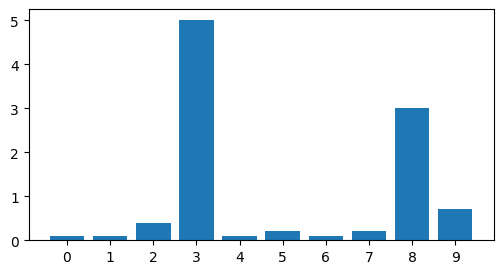

In [ ]:
from matplotlib import pyplot as plt

logits = [0.1, 0.1, 0.4, 5, 0.1, 0.2, 0.1, 0.2, 3, 0.7]

plt.figure(figsize=(6, 3))
plt.bar(range(0, 10), logits)
plt.xticks(range(0, 10))
plt.show()

Самый большой логит у тройки, что верно. Но и у восьмерки он большой, так как эти цифры похожи.


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/distilation_mnist_3.png"  width="200" height="200">


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/distilation_mnist_8.png"  width="200" height="200">

То есть логиты содержат дополнительную полезную информацию.


Когда мы превратим их в вероятности, она сохранится.

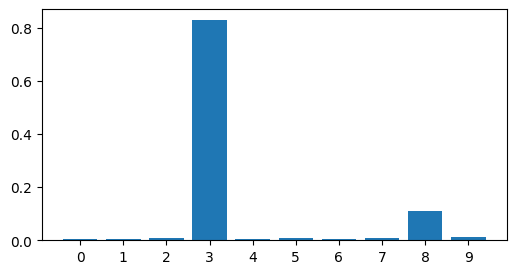

In [ ]:
import torch
from torch.nn.functional import softmax

probs = softmax(torch.tensor(logits), dim=0)

plt.figure(figsize=(6, 3))
plt.bar(range(0, 10), probs)
plt.xticks(range(0, 10))
plt.show()

А вот после того, как мы превратим вектор вероятностей в метку (one_hot вектор), эта дополнительная информация пропадет при округлении.

In [ ]:
one_hot = (probs >= probs.max()).int()
print("One hot ", one_hot)

One hot  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


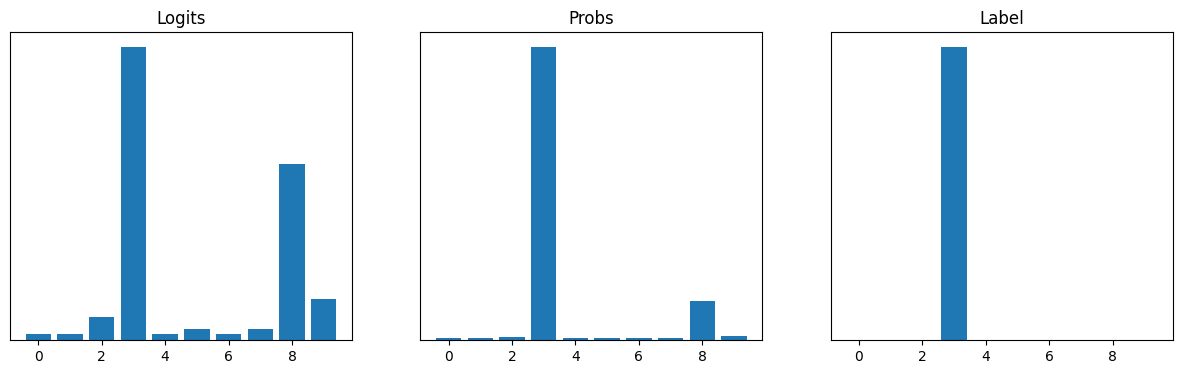

In [ ]:
import numpy as np

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=False)


def bar(ax, y, title):
    x = range(0, 10)
    ax.bar(x, np.array(y))
    ax.set_title(title)
    ax.set_yticks([])


bar(ax1, logits, "Logits")
bar(ax2, probs, "Probs")
bar(ax3, one_hot, "Label")

plt.plot()
plt.show()

Чтобы не терять информацию, можно предсказывать не метку, а весь вектор вероятностей, который получается на выходе большой модели.



[[colab] 🥨 Обучение без использования разметки BYOL](https://colab.research.google.com/drive/13bolgaT23R_l8OcCyhUpeWPdwJEIKqLR?usp=sharing).

# CLIP

Contrastive Language-Image Pre-training

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/clip_idea.png"  width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2103.00020">Learning Transferable Visual Models From Natural Language Supervision</a></em></center>

Для обучения модели был создан новый датасет, включающий 400M пар изображение–текст.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/clip_classifier.png"  width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2103.00020">Learning Transferable Visual Models From Natural Language Supervision</a></em></center>

Для использования в качестве классификатора достаточно создать текстовый эмбеддинг для слова, описывающего каждый класс, а затем сравнить его с эмбеддингом изображения.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L08/clip_performance.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2103.00020">Learning Transferable Visual Models From Natural Language Supervision</a></em></center>

Точность классификации не дотягивает до SOTA supervised моделей, но зато работает без дообучения на различных датасетах.

### Как использовать

Установка:

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.3 MB/s eta 0:00:00


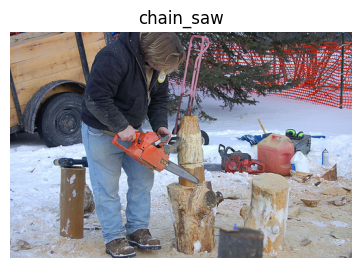

In [ ]:
img, class_num = microImgNet[200]
show(img, microImgNet.labels[200][1], 0)

На вход CLIP надо подать список текстов, на выходе получим оценку того, какой из них больше всего подходит к изображению.

In [ ]:
texts = [
    "A man with a gasoline saw is getting firewood",
    "Santa Claus sleigh",
    "chain saw",
    "cat",
    "dog",
]

Можно использовать разные backbone:

In [ ]:
import clip

print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


Создаем экземпляр модели:

In [ ]:
import clip

model, preprocess = clip.load("ViT-B/32", device="cpu")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 144MiB/s]


Дополнительно получили объект `preprocess` с необходимыми трансформациями. Подготовим с их помощью изображение и токенизируем текст:



In [ ]:
image = preprocess(img).unsqueeze(0)
text = clip.tokenize(texts)

Теперь можно запускать

`Given a batch of images and a batch of text tokens, returns two Tensors, containing the logit scores corresponding to each image and text input. The values are cosine similarities between the corresponding image and text features, times 100.`

[[9.9127930e-01 5.4925490e-06 8.7150587e-03 5.6151428e-08 2.9277155e-07]]


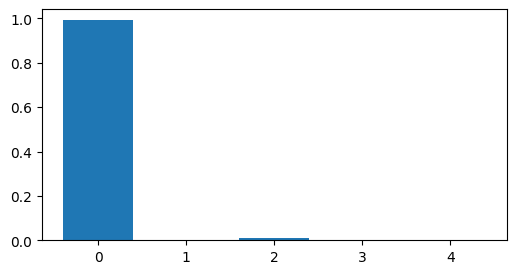

In [ ]:
with torch.no_grad():
    logits_per_image, _ = model(image, text)
    probs = logits_per_image.softmax(dim=-1).numpy()

print(probs)

plt.figure(figsize=(6, 3))
plt.bar(range(len(texts)), probs.flatten())
plt.show()

### Получение embedding

Вот так можно извлечь признаки для картинки и для текста:

In [ ]:
image_features = model.encode_image(image).detach().cpu()
text_features = model.encode_text(text).detach().cpu()
print("Image", image_features.shape)
print("Text", text_features.shape)

Image torch.Size([1, 512])
Text torch.Size([5, 512])


Чтобы сравнить вектора признаков изображений и текстов, нам нужна какая-то метрика расстояния между ними. Удобно использовать [косинусное расстояние 📚[wiki]](https://en.wikipedia.org/wiki/Cosine_similarity):

$ \large \text{cosine_similarity} = \cos(\theta) = \dfrac{a \cdot b  }{|a||b|} $

Если вектора имеют единичную длину, то косинус угла между ними равен скалярному произведению :

$\large \text{cosine_similarity} = a \cdot b $

Эмбеддинги на выходе CLIP не нормализованы:

In [ ]:
print(np.linalg.norm(image_features[0]))

10.169522


Нормализуем их:

In [ ]:
from torch.nn.functional import normalize

image_features = normalize(image_features)
text_features = normalize(text_features)

print(np.linalg.norm(image_features[0].cpu()))
print(np.linalg.norm(text_features.cpu(), axis=1))

0.99999994
[1.        1.        1.        1.        1.0000001]


Теперь мы можем посчитать скалярное произведение вектора признаков для каждого текста с картинкой и понять, насколько они похожи:

In [ ]:
similarities = []
for t in text_features:
    sim = torch.dot(image_features[0], t)
    similarities.append(sim.item())
print(similarities)

[0.3043336570262909, 0.18330010771751404, 0.2569942772388458, 0.13746914267539978, 0.1539825052022934]


Аналогичный результат получится при матричном умножении признаков:

In [ ]:
sims = torch.matmul(text_features, image_features.T)
print(sims.detach().cpu().tolist())

[[0.3043336570262909], [0.18330010771751404], [0.25699424743652344], [0.13746915757656097], [0.1539825201034546]]


Разрыв уже не такой внушительный, как после softmax:

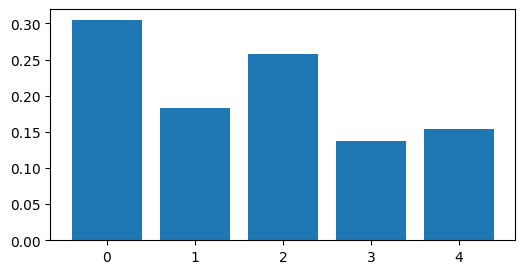

In [ ]:
plt.figure(figsize=(6, 3))
plt.bar(range(len(similarities)), similarities)
plt.show()

Но можно умножить расстояния на константу перед отправкой в softmax:

In [ ]:
chilled_sims = sims.flatten() * 100

И тогда результат совпадет с тем, что выдал CLIP:

[9.9127918e-01 5.4925799e-06 8.7150913e-03 5.6151741e-08 2.9277209e-07]


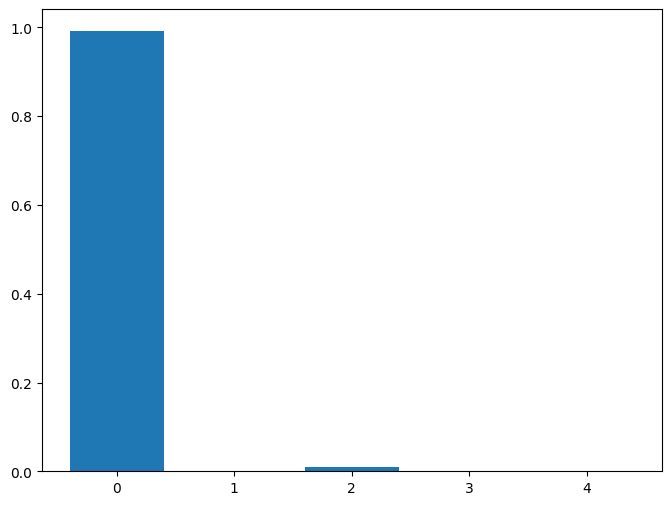

In [ ]:
s = chilled_sims.softmax(dim=0).numpy()
print(s)
plt.figure(figsize=(8, 6))
plt.bar(range(len(s)), s)
plt.show()

### Классификация ImageNet

Создадим из названий классов простые текстовые описания и напечатаем 10 штук для примера:

In [ ]:
descriptions = []
for val in imagenet_labels.values():
    name = val[1].replace("_", " ")
    descriptions.append(f"a photo of {name}")
print(descriptions[0:10])

['a photo of tench', 'a photo of goldfish', 'a photo of great white shark', 'a photo of tiger shark', 'a photo of hammerhead', 'a photo of electric ray', 'a photo of stingray', 'a photo of cock', 'a photo of hen', 'a photo of ostrich']


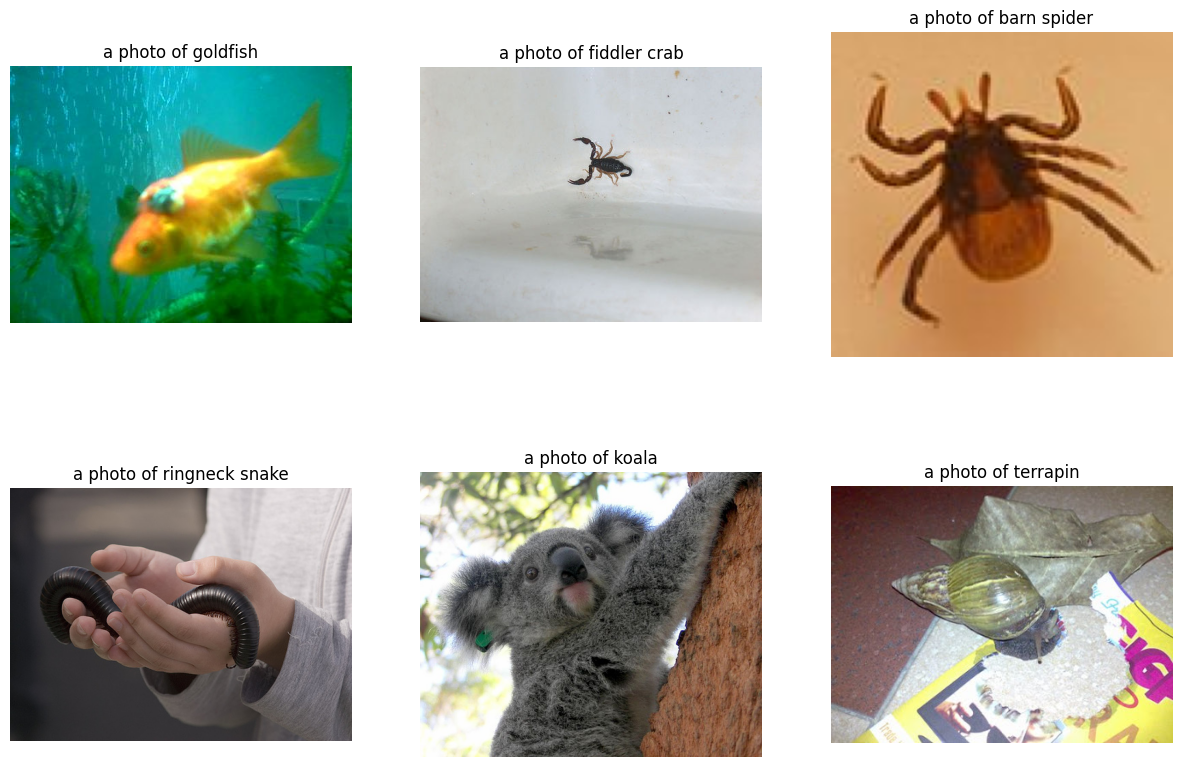

In [ ]:
import clip

img, label = microImgNet[0]

model, preprocess = clip.load("ViT-B/32", device=device)


for i in range(6):
    img, label = microImgNet[i * 6]
    name = microImgNet.labels[i * 6][1]

    image = preprocess(img).unsqueeze(0).to(device)
    text = clip.tokenize(descriptions).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        class_num = probs.argmax()
        descr = descriptions[class_num]
        show(img, descr, i)

#Практические рекомендации

*  Используйте EfficientNet  качестве baseline
*  Для доступа к новым моделям используйте [HuggingFace 🛠️[doc]](https://huggingface.co/)
*  Не учите трансформеры с нуля


<font size="6">Литература</font>

<font size="5">AlexNet:</font>

* [[article] 🎓 ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
* [[blog] ✏️ Подробнее про AlexNet](https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide)

<font size="5">ZFNet:</font>

* [[arxiv] 🎓 Visualizing and Understanding Convolutional Networks (Zeiler et al., 2013)](https://arxiv.org/abs/1311.2901)

<font size="5">VGG:</font>

* [[arxiv] 🎓 Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan et al., 2014)](https://arxiv.org/abs/1409.1556)
* [[doc] 🛠️ Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

<font size="5">GoogLeNet:</font>

* [[arxiv] 🎓 Going Deeper with Convolutions (Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842)

<font size="5">Global Average Pooling:</font>

* [[arxiv] 🎓 Network In Network, Lin et al., 2013](https://arxiv.org/abs/1312.4400)
* [[blog] ✏️ Max Pooling and Global Average Pooling](https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md)
* [[arxiv] 🎓 Global Pooling, More than Meets the Eye: Position Information is Encoded Channel-Wise in CNNs (Islam et al., 2021)](https://arxiv.org/abs/2108.07884)

<font size="5">ResNet:</font>

* [[arxiv] 🎓 Deep Residual Learning for Image Recognition (He et al., 2015)](https://arxiv.org/abs/1512.03385)

<font size="5">Fixup Initialization:</font>

* [[arxiv] 🎓 Fixup Initialization: Residual Learning Without Normalization (Zhang et. al, 2019)](https://arxiv.org/abs/1901.09321)

<font size="5">ResNeXt:</font>

* [[arxiv] 🎓 Aggregated Residual Transformations for Deep Neural Networks (Xie et al., 2016)](https://arxiv.org/abs/1611.05431)
* [[blog] ✏️ Review of ResNet Family: from ResNet to ResNeSt](https://sheng-fang.github.io/2020-05-20-review-resnet-family/)

<font size="5">DenseNet:</font>

* [[arxiv] 🎓 Densely Connected Convolutional Networks (Huang et al., 2016)](https://arxiv.org/abs/1608.06993)

<font size="5">WideResNet:</font>

* [[arxiv] 🎓 Wide Residual Networks (Zagoruyko et al., 2016)](https://arxiv.org/abs/1605.07146)

<font size="5">SENet:</font>

* [[arxiv] 🎓 Squeeze-and-Excitation Networks (Hu et al., 2017)](https://arxiv.org/abs/1709.01507)
* [[blog] ✏️ Channel Attention and Squeeze-and-Excitation Networks (SENet)](https://blog.paperspace.com/channel-attention-squeeze-and-excitation-networks/)

<font size="5">MobileNet:</font>

* [[arxiv] 🎓 MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Howard et al., 2017)](https://arxiv.org/abs/1704.04861)

<font size="5">EfficientNet:</font>

* [[arxiv] 🎓 EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)](https://arxiv.org/abs/1905.11946)

<font size="5">Visual Transformer:</font>

* [[arxiv] 🎓 Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)
* [[blog] ✏️ Разбор ViT](https://viso.ai/deep-learning/vision-transformer-vit/)
* [[arxiv] 🎓 An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)](https://arxiv.org/abs/2010.11929)

<font size="5">Дополнительно:</font>
* [[blog] ✏️  A Tutorial on Filter Groups (Grouped Convolution)](https://blog.yani.ai/filter-group-tutorial/)
* [[arxiv] 🎓 Benchmark Analysis of Representative Deep Neural Network Architectures (Bianco et al., 2018)](https://arxiv.org/abs/1810.00736)
* [[arxiv] 🎓 Neural Architecture Search with Reinforcement Learning (Zoph et al., 2016)](https://arxiv.org/abs/1611.01578)